In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
from constrainedgp import CGP
import finitedimensionalgp as fdgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import virtobs as vo
import tmg_samplers as tmg

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )

theme.apply()

# the data

In [2]:
n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples('SE')

l_hat = l_hat*ns

n = n_ceft
cs2 = cs2_ceft

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=200, mu_low=2.35, mu_high=2.75)
cs2_pqcd_sigma = np.zeros_like(cs2_pqcd)


n = np.concatenate((n, n_pqcd))*ns
cs2 = np.concatenate((cs2, cs2_pqcd))

cs2_sigma = np.concatenate((cs2_ceft_sigma,
                             cs2_pqcd_sigma))

n_test = np.linspace(n[0], 40*ns, 200)

# integral matrix building

In [10]:
def build_C_trap(Xc, n0, n_mu):
    """
    Xc: sorted (N_c,) grid for cs2
    n0: scalar lower limit
    n_mu: (M,) points where mu-bounds are specified

    Returns C: (M, N_c) such that (C @ y_c)[i] ≈ ∫_{n0}^{n_mu[i]} cs2(u)/u du
    """
    X = np.asarray(Xc).ravel()
    M = len(n_mu)
    Nc = len(X)
    C = np.zeros((M, Nc))

    # ensure n0 inside grid range
    if not (X[0] <= n0 <= X[-1]):
        raise ValueError("n0 must lie within the constraint grid Xc range.")

    # indices to start integration
    # find j0 so that X[j0] <= n0 <= X[j0+1]
    j0 = np.searchsorted(X, n0) - 1
    j0 = np.clip(j0, 0, Nc-2)

    # precompute segment widths and 1/x factors
    dx = np.diff(X)
    invX = 1.0 / X

    for i, n_target in enumerate(n_mu):
        if n_target < n0:
            continue  # integral is zero if target before n0
        # find k so that X[k] <= n_target <= X[k+1]
        k = np.searchsorted(X, n_target) - 1
        k = np.clip(k, 0, Nc-2)

        # full segments from max(j0,0) .. k-1
        j_start = j0
        if n0 > X[j0]:  # partial first cell [n0, X[j0+1]]
            # weight only on nodes j0 and j0+1 for the partial length
            L = X[j0+1] - n0
            # trapezoid on cs2/x over partial length
            C[i, j0  ] += 0.5 * L * invX[j0]
            C[i, j0+1] += 0.5 * L * (1.0 / X[j0+1])
            j_start = j0+1
        # full cells
        for j in range(j_start, k):
            L = dx[j]
            C[i, j  ] += 0.5 * L * invX[j]
            C[i, j+1] += 0.5 * L * (1.0 / X[j+1])

        # partial last cell [X[k], n_target]
        if n_target > X[k]:
            L = n_target - X[k]
            C[i, k  ] += 0.5 * L * invX[k]
            C[i, k+1] += 0.5 * L * (1.0 / X[k+1])

    return C

# integral observations

In [11]:
n_int = np.linspace(n_ceft[0], n_pqcd[-1], 400)*ns

C_int = build_C_trap(n_int, n0=n_ceft[0]*ns, n_mu=n_pqcd*ns)


In [12]:
kernel = Kernel('SE', sigma=sigma_hat, l=l_hat)

cgp = CGP(kernel=kernel, x_train=n, y_train=cs2, x_test=n_test, var_f=cs2_sigma, prior_mean=cs2_hat, jitter=1e-8)

In [13]:
mean_train, mean_i = cgp._set_means(n, n_int)
mean_train = np.ones_like(n) * mean_train
mean_i = np.ones_like(n_int) * mean_i # perhaps should be zero instead

In [14]:
e0, p0,n0, mu0 = anal.get_ceft_ini()
mu_pqcd = np.linspace(2.35, 2.75, len(n_pqcd)) * 1000
int_train = np.log(mu_pqcd/mu0)

In [15]:
K_ss = cgp._set_K_11(n, var_f=None, stabilise=True, jitter_value=cgp.jitter)  # training cov + noise if any
K_1i = cgp.kernel.compute(n, n_int)
K_ii_prior = cgp.kernel.compute(n_int)

# 3) build joint mean and Kyy prior
#mu_joint = np.concatenate([mean_train, mean_i])
K_si = K_1i
K_is = K_si.T
K_ii = K_ii_prior

# 4) build observation covariance K_11
# top-left: K_ss + observation noise for training (if you have var_f include it)
# assume observation noise Var_ytrain = diag(var_f**2) or scalar
# for simplicity use existing K_11 which may already include noise.
top_left = K_ss
top_right = K_si
bottom_left = K_is
bottom_right = C_int @ K_ii @ C_int.T    # Cov(C f, C f)

# assemble K_yy
K_11 = np.block([[ top_left,          top_right @ C_int.T ],
                 [ C_int @ bottom_left, bottom_right         ]])

# the observed y vector concatenates cs2 and y_C
y_joint = np.concatenate([ cs2, int_train ])

# joint prior mean for these observations:
mu_y = np.concatenate([ mean_train, C_int @ mean_i ])

# 5) compute cross-cov between test f* and joint observations
# compute K_ts and K_tc
K_2s = cgp.kernel.compute(n_test, n)   # K(X_*, X_s)
K_2c = cgp.kernel.compute(n_test, n_int)    # K(X_*, X_c)
K_21 = np.hstack([ K_2s, K_2c @ C_int.T ])  # shape (n_test, n_obs)

# 6) Cholesky solve
jitter = 1e-10 * np.mean(np.diag(K_11))
L = cholesky(K_11 + jitter*np.eye(K_11.shape[0]), lower=True)
alpha = cho_solve((L, True), (y_joint - mu_y))

# posterior mean and cov at n_test
_, mean_test = cgp._set_means(n, n_test)
mean_star = mean_test + K_21 @ alpha
v = solve_triangular(L, K_21.T, lower=True)

K_22 = cgp.kernel.compute(n_test)
cov_star = K_22 - (v.T @ v) 

# mu_star is posterior mean for f at n_test given both training and integral pseudo-observations.


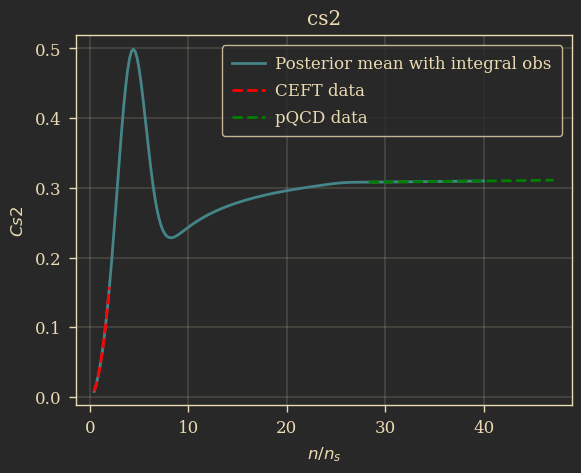

In [16]:
plt.plot(n_test/ns, mean_star, label='Posterior mean with integral obs')
plt.plot(n_ceft, cs2_ceft, 'r--', label='CEFT data')
plt.plot(n_pqcd, cs2_pqcd, 'g--', label='pQCD data')
plt.xlabel(r"$n/n_s$")
plt.ylabel(r"$Cs2$")
plt.title("cs2")
plt.legend()
plt.show()

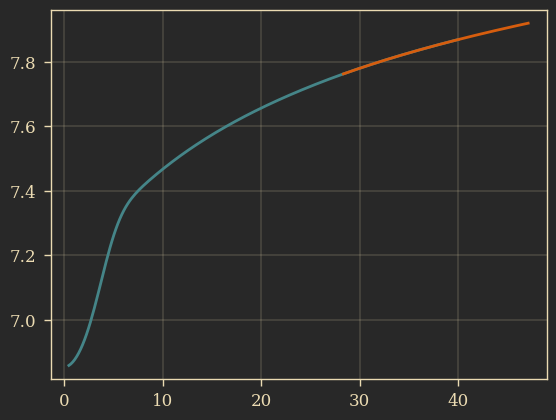

In [17]:
eos = EosProperties(n = n_test, phi=None, epsi_0=e0, p_0=p0, mu_0=mu0, cs2 = mean_star)
vals = eos.get_all()
plt.plot(n_test/ns, np.log(vals['mu']), label='Posterior mu with integral obs')
#plt.plot(n_pqcd, np.log(a), label='μ min')
#plt.plot(n_pqcd, np.log(bb), label='μ max')
plt.plot(n_pqcd, np.log(mu_pqcd), label='pQCD mu')
plt.show()

In [18]:
eps = 1e-5

In [19]:
n_c = np.linspace(n_ceft[-1], n_pqcd[0], 100) * ns
a_c = np.zeros_like(n_c) + eps
b_c = np.ones_like(n_c) -eps

d = len(n_c)
A_bounds = np.vstack([np.eye(d), -np.eye(d)])
b_bounds = np.concatenate([-a_c, b_c])

In [20]:
K_sc = cgp.kernel.compute(n, n_c)
K_ic =  C_int @ (cgp.kernel.compute(n_int, n_c))
K_1c = np.vstack([K_sc, K_ic])

K_cc = cgp.kernel.compute(n_c, n_c)

K_2c = cgp.kernel.compute(n_test, n_c) # cross cov b/w test and constraint points


In [21]:
_, mean_constr = cgp._set_means(n, n_c)
mu_Z = mean_constr + (K_1c.T @ alpha) # E[Y(X_c)]

v_c = solve_triangular(L, K_1c, lower=True, check_finite=False) # usual GP eqs
Sigma_Z = K_cc - (v_c.T @ v_c)        # Cov[Y(X_c)]

# conditional cross-covariance: k(x_*, X_c) - k(X_s, x_*)^T Sigma_s^{-1} k(X_s, X_c)
# k(X_s, x_*)^T Sigma_s^{-1} k(X_s, X_c) = k(X_s, x_*)^T (L L^T)^{-1} k(X_s, X_c) = (L^{-1} k(X_s, x_*))^T (L^{-1} k(X_s, X_c))
v_t = v # (L^{-1} k(X_s, x_*))^T 

v_c = solve_triangular(L, K_1c, lower=True, check_finite=False) #  (L^{-1} k(X_s, X_c))

Sigma_YZ = K_2c - v.T @ v_c   # Cov(Y(x_*), Y(X_c))


In [22]:
A = A_bounds
b = b_bounds

In [23]:

import cvxpy as cp

def project_to_constraints(A, b, z_raw):
    z = cp.Variable(len(z_raw))
    obj = cp.Minimize(cp.sum_squares(z - z_raw))
    constr = [A @ z + b >= 0]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.PROXQP, warm_start=True, verbose=False)
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError("Projection failed to find a feasible point.")
    return np.array(z.value)

z0 = project_to_constraints(A, b, mu_Z) # projection just makes it 4x faster

Z_samples = tmg.sample_tmvn_ess(z0, 
                                        Sigma_Z, 
                                        A, 
                                        b, 
                                        X=None, y=None, 
                                        n_samples=50,
                                        eta_init=200, 
                                        update_eta=True)

Lz = cholesky(Sigma_Z + jitter * np.eye(Sigma_Z.shape[0]), lower=True)
inv_Sz = cho_solve((Lz, True), np.eye(Sigma_Z.shape[0]))
S_star = cov_star - Sigma_YZ @ inv_Sz @ Sigma_YZ.T
Z_centered = Z_samples - mu_Z
m_stars = mean_star + (Sigma_YZ @ inv_Sz @ Z_centered.T).T
rng = np.random.default_rng()

n_t = S_star.shape[0]
n_samples = m_stars.shape[0]

eps = rng.multivariate_normal(
    mean=np.zeros(n_t),
    cov=S_star,
    size=n_samples,
    check_valid='ignore', 
    tol=1e-9               
)
Ystar_samples = m_stars + eps

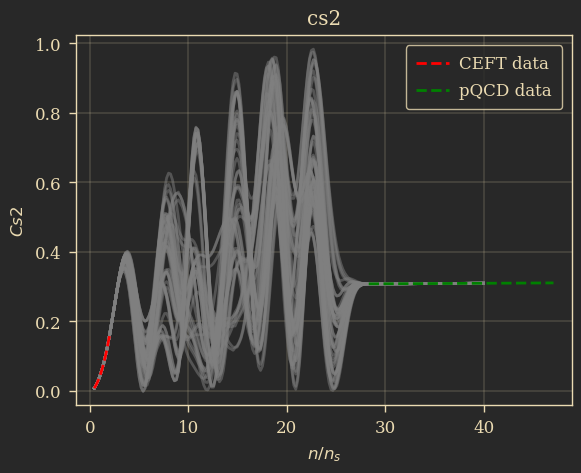

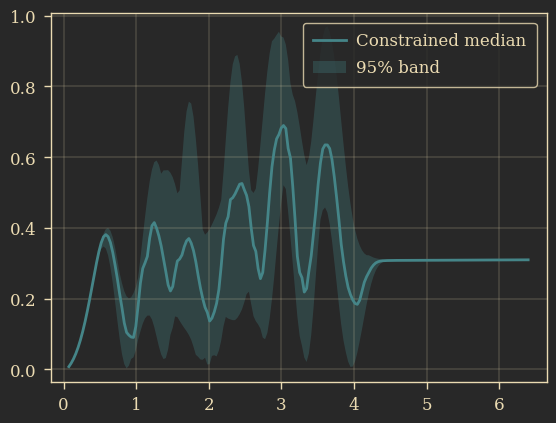

In [24]:
for i in range(len(Ystar_samples)):
    plt.plot(n_test/ns, Ystar_samples[i],color='grey', alpha=0.5)
plt.plot(n_ceft, cs2_ceft, 'r--', label='CEFT data')
plt.plot(n_pqcd, cs2_pqcd, 'g--', label='pQCD data')
plt.xlabel(r"$n/n_s$")
plt.ylabel(r"$Cs2$")
plt.title("cs2")
plt.legend()
plt.show()



q_lower, q_median, q_upper = np.quantile(Ystar_samples, [0.025, 0.5, 0.975], axis=0)
plt.plot(n_test, q_median, '-', lw=2, label='Constrained median')
plt.fill_between(n_test, q_lower, q_upper, alpha=0.3, label='95% band')
plt.legend()
plt.show()

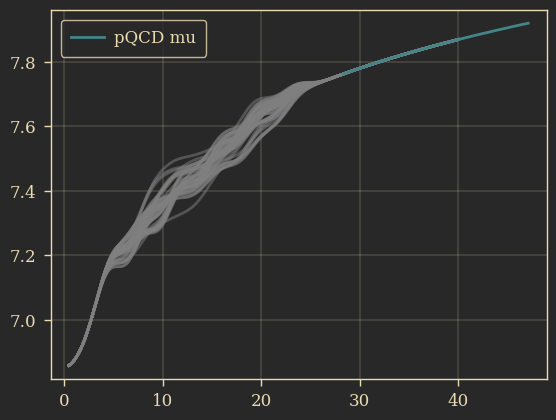

In [ ]:
for i in range(len(Ystar_samples)):
    eos = EosProperties(n = n_test, phi=None, 
                        epsi_0=e0, p_0=p0, 
                        mu_0=mu0, cs2 = Ystar_samples[i])
    vals = eos.get_all()
    plt.plot(n_test/ns, np.log(vals['mu']),
             color='grey', alpha=0.5)
plt.plot(n_pqcd, np.log(mu_pqcd), label='pQCD mu')
plt.legend()
plt.show()

In [26]:
np.any((np.where(Ystar_samples<0)))

True

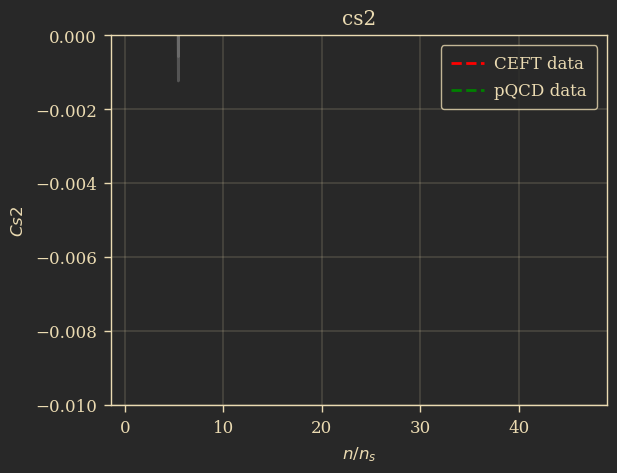

In [27]:
for i in range(len(Ystar_samples)):
    plt.plot(n_test/ns, Ystar_samples[i],color='grey', alpha=0.5)
plt.plot(n_ceft, cs2_ceft, 'r--', label='CEFT data')
plt.plot(n_pqcd, cs2_pqcd, 'g--', label='pQCD data')
plt.xlabel(r"$n/n_s$")
plt.ylabel(r"$Cs2$")
plt.title("cs2")
plt.legend()
plt.ylim(-0.01,0)
plt.show()

In [3]:
from  constrain_on_chempot import generate_constrained_sample, custom_build_w_vector
n_ceft, cs2_ceft_avg, phi_ceft_sigma, e_ini, p_ini, mu_ini, n_crust, e_crust, p_crust, cs2_crust = pc.make_conditioning_eos()


cs2_test, x_test, X_hat, n_ceft_end_hat, l_hat = generate_constrained_sample(
    n_ceft, cs2_ceft, cs2_ceft_sigma, n_crust, cs2_crust, mu_ini, x_test_end=40
)

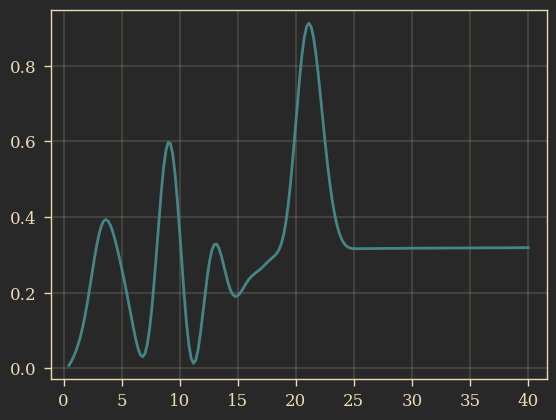

In [4]:
plt.plot(x_test/ns, cs2_test.flatten())
plt.show()

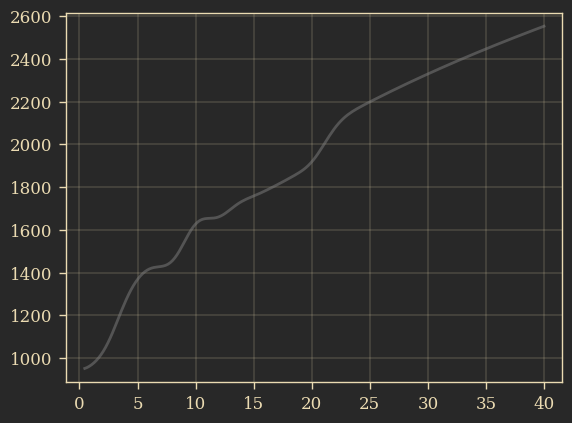

In [5]:
e0, p0,n0, mu0 = anal.get_ceft_ini()

eos = EosProperties(n = x_test/ns, phi=None, 
                    epsi_0=e0, p_0=p0, 
                    mu_0=mu0, cs2 = cs2_test)
vals = eos.get_all()

plt.plot(n_test/ns, (vals['mu']),
             color='grey', alpha=0.5)
plt.show()

In [2]:
from  constrain_on_chempot import generate_bounded_sample
n_ceft, cs2_ceft_avg, phi_ceft_sigma, e_ini, p_ini, mu_ini, n_crust, e_crust, p_crust, cs2_crust = pc.make_conditioning_eos()


cs2_test, x_test, X_hat, n_ceft_end_hat, l_hat = generate_bounded_sample(
    n_ceft, cs2_ceft, cs2_ceft_sigma, n_crust, cs2_crust, mu_ini, x_test_end=40
)
